# 1 综述
本章节集中讨论机器学习中要解决的第二个现实问题：分类，主要包含以下几个形式：
1. 二分类：样本有且仅有互斥的两个类别，单一样本仅从属于其中一个类列；比如，识别一个信贷用户是否是欺诈用户。
2. 多分类：样本有互斥的多个类别，单一样本仅从属于其中一个类列；比如，识别一个水果是苹果、梨及香蕉等。
3. 多标签分类：样本有多个类别，单一样本属于其中一个或多个类列；比如，一篇新闻从属的标签：新闻、军事及国内等。
4. 多输出-多类分类（简称多输出分类）：多标签分类的简单泛化，在这里每一个标签可以是多类别的/不同的数值；比如针对多分类中的新闻问题，我们可能要追加预测一级标签报社名。

案例基于美国高中生和人口调查局职员手写的 **7w** 张数字图片（28\*28）[MNIST](https://www.openml.org/d/554)数据集进行演练：

(-0.5, 27.5, 27.5, -0.5)

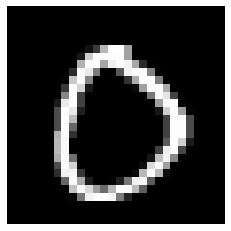

In [1]:
import numpy as np
import pandas as pd
from pandas import Series,DataFrame
import matplotlib
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

def GetData(name,dtype):
    X,y = fetch_openml(name,version=1,return_X_y=True,as_frame=False)
    data = np.hstack((X,y[:,None].astype(dtype)))
    np.random.seed(11)
    np.random.shuffle(data) # 乱序排列数据，避免数据顺序对后续分析和算法效果的影响
    X = data[:,:data.shape[1]-1]
    y = data[:,-1]
    return X,y

X,y = GetData('mnist_784',int)

plt.imshow(X[0].reshape(28,28),
           cmap = 'gray', # 颜色图谱
           interpolation="nearest") # 插值方法
plt.axis("off") # 去除坐标轴

# 2 二分类
稍作变换，将原始的y从0~9的标签转换为识别 **5** & **非5** 的二分类问题，然后我们层级渐进的进行二分类建模，梳理如下：
1. 直接建模：展示建模流程，梳理分类模型评价指标。
2. 叠加数据预处理：评估数据预处理的重要性。
3. 叠加交叉验证调参：评估参数的重要性。
4. 更换非线性模型

## 2.1 SGD分类模型
- 标签生成：

In [2]:
y_bin = (y == 5) + 0

- 切分数据：

In [3]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(X,y_bin,test_size=0.3,random_state=7)

- 模型训练：

In [4]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(random_state=7) # 因为随机梯度下降，设定随机种子
sgd.fit(x_train,y_train)

SGDClassifier(random_state=7)

- 模型预测：

In [5]:
y_train_pred = sgd.predict(x_train)# 输出预测值 sgd.decision_function(x_train)

- 模型评估：

In [6]:
from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score,roc_auc_score

def BinEvaluate(y,y_pred):
    print('目标浓度：')
    print(Series(y).value_counts()/len(y))
    print('\n混淆矩阵：')
    print(confusion_matrix(y,y_pred)) # 行：y，列：y-pred
    print('准确率：%s' % (precision_score(y,y_pred))) # 预测某分类中 *% 的可能性是正确的
    print('召回率：%s' % (recall_score(y,y_pred))) # 实际某分类中 *% 的真值被识别
    print('F1 值：%s' % (f1_score(y,y_pred))) #  高 F1 值，需要召回率和准确率同时高
    print('ROC：%s' % (roc_auc_score(y,y_pred)))

BinEvaluate(y_train,y_train_pred)

目标浓度：
0    0.910286
1    0.089714
dtype: float64

混淆矩阵：
[[44235   369]
 [ 1440  2956]]
准确率：0.8890225563909775
召回率：0.6724294813466788
F1 值：0.7657039243621293
ROC：0.8320783403504983


从评价指标可以看出，召回率不尽如人意，所以评估分类模型时，**不建议使用准确率作为评价指标**，因为当样本比严重失衡时，将全部结果预测为占绝对多数的单一类别时，准确率也极高，然而那样的模型是没有实际意义的。

## 2.2 叠加数据预处理
- 归一化：

In [7]:
from sklearn.preprocessing import MinMaxScaler
mm = MinMaxScaler()
x_train_new = mm.fit_transform(x_train)
x_test_new = mm.transform(x_test)# 必须使用训练集的转换标准转换测试集

- 模型的训练 & 评估：

In [8]:
# 训练
sgd = SGDClassifier(random_state=7)
sgd.fit(x_train_new,y_train)
# 评估
BinEvaluate(y_train,sgd.predict(x_train_new))

目标浓度：
0    0.910286
1    0.089714
dtype: float64

混淆矩阵：
[[44432   172]
 [  990  3406]]
准确率：0.9519284516489659
召回率：0.7747952684258417
F1 值：0.854276398294457
ROC：0.8854695560136562


经过归一化后的数据建模效果得到了较大的提升，其中召回率提升明显。
## 2.3 叠加交叉验证调参
因为上文中表达了准确率的缺陷，综合准确率和召回率的F1值对交叉验证进行评估。
### 2.3.1 基于 *2.1* 叠加5折交叉验证

In [9]:
from sklearn.model_selection import cross_val_score
sgd = SGDClassifier(random_state=7)
cross_val_score(sgd,x_train,y_train,cv=5,scoring='f1')

array([0.74821514, 0.8117506 , 0.78548695, 0.81288724, 0.76979167])

### 2.3.2 基于 *2.2* 叠加5折交叉验证

In [10]:
sgd = SGDClassifier(random_state=7)
cross_val_score(sgd,x_train_new,y_train,cv=5,scoring='f1')

array([0.86305539, 0.84530064, 0.8283208 , 0.85859729, 0.84741641])

通过交叉验证比较，我们可以发现归一化对模型的提升是很显著的、稳定的，所以我们使用归一化后建立的模型进行下一步分析。
### 2.3.3 调参
我们对**随机种子**的数值进行下评估：

In [11]:
for i in range(10):
    sgd = SGDClassifier(random_state=i)
    f1 = cross_val_score(sgd,x_train_new,y_train,cv=5,scoring='f1')
    print('随机种子：%s,平均F1值：%s。' % (i,np.mean(f1)))

随机种子：0,平均F1值：0.830751747067214。
随机种子：1,平均F1值：0.8558710462462388。
随机种子：2,平均F1值：0.8311852923297757。
随机种子：3,平均F1值：0.8368578007938068。
随机种子：4,平均F1值：0.8462409496237802。
随机种子：5,平均F1值：0.8474147274409297。
随机种子：6,平均F1值：0.8187530528265754。
随机种子：7,平均F1值：0.8485381058166311。
随机种子：8,平均F1值：0.8438734396861479。
随机种子：9,平均F1值：0.8235415881732104。


选定数字 **1** 作为随机种子，建立模型并评估在测试集上的效果。

In [12]:
from sklearn.model_selection import cross_val_predict
sgd = SGDClassifier(random_state=1)
sgd.fit(x_train_new,y_train)
print('训练集：')
pred_train = sgd.predict(x_train_new)
BinEvaluate(y_train,pred_train)
print('\n测试集：')
pred_test = sgd.predict(x_test_new)
BinEvaluate(y_test,pred_test)

训练集：
目标浓度：
0    0.910286
1    0.089714
dtype: float64

混淆矩阵：
[[44152   452]
 [  658  3738]]
准确率：0.8921241050119332
召回率：0.8503184713375797
F1 值：0.8707197763801537
ROC：0.9200924255172339

测试集：
目标浓度：
0    0.908714
1    0.091286
dtype: float64

混淆矩阵：
[[18875   208]
 [  305  1612]]
准确率：0.8857142857142857
召回率：0.8408972352634324
F1 值：0.8627241102488628
ROC：0.914998740777972


预测效果还是令人满意的，衰变也不是很严重。
## 2.4 随机森林建模
我们知道图像识别应该不太适用于SGD线性分类，所以我们准备将模型换成随机森林来比较下:

训练集：
目标浓度：
0    0.910286
1    0.089714
dtype: float64

混淆矩阵：
[[44594    10]
 [  444  3952]]
准确率：0.9974760222110045
召回率：0.8989990900818926
F1 值：0.9456807848767648
ROC：0.9493874474712216

测试集：
目标浓度：
0    0.908714
1    0.091286
dtype: float64

混淆矩阵：
[[19058    25]
 [  293  1624]]
准确率：0.9848392965433597
召回率：0.8471570161711007
F1 值：0.9108244531688167
ROC：0.9229234748098599


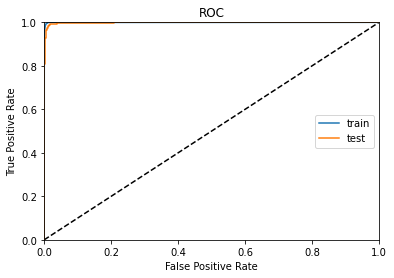

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve

def PltRoc(y_train,y_test,pred_train,pred_test):
    fpr_train,tpr_train,thresholds_train = roc_curve(y_train,pred_train)
    fpr_test,tpr_test,thresholds_test = roc_curve(y_test,pred_test)
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_train,tpr_train,label='train')
    plt.plot(fpr_test,tpr_test,label='test')
    plt.legend(loc="right")
    plt.title('ROC')
    plt.show()

rf = RandomForestClassifier(n_estimators=200,
                            criterion='entropy', # gini/entropy
                            max_depth=None,
                            min_samples_split=50,
                            max_features='auto',
                            n_jobs=-1,
                            random_state=7)

rf.fit(x_train_new,y_train)

print('训练集：')
pred_train = rf.predict(x_train_new)
BinEvaluate(y_train,pred_train)

print('\n测试集：')
pred_test = rf.predict(x_test_new)
BinEvaluate(y_test,pred_test)

pred_proba_train = rf.predict_proba(x_train_new)[:,1]
pred_proba_test = rf.predict_proba(x_test_new)[:,1]

PltRoc(y_train,y_test,pred_proba_train,pred_proba_test)

识别精度有了显著的提升，随机森林中又有多个参数可以调参，如果叠加交叉验证进行调参的话说不定会有更好的结果。不过，由于随机森林参数多，参数间存在相互影响，所以后面我们会介绍一种超参数搜索的方法，此处就不展开了。
# 3 多分类
下面我们来看看多分类问题，能想到的一种简单的方法除了直接进行多类的判别外，另一种就是将多类问题拆解成多个二分类问题（有些算法是严格的二分类算法），所以有如下思路：
1. 直接处理多分类：随机森林、朴素贝叶斯等。
2. 一对所有（OvA）：构建与类别数目 **N** 等同的 **N** 个互斥二分类器，单个分类器将某类作为正例，其余作为反例，选择决策分数最高的类别作为最终分类结果。
3. 一对一（OvO）：将 **N** 个类别中的数据基于类别两两配对，构建 **N\*(N−1)/2** 个二分类器，多个分类器基于类别结果投票决定最终分类结果。

## 3.1 多分类建模
我们将原来的问题从判断 **5** & **非5** 的问题回归到分类 **0~9** 的识别上：

In [14]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=7)

mm = MinMaxScaler() # 也可以试试标准化：StandardScaler
x_train_mm = mm.fit_transform(x_train)
x_test_mm = mm.transform(x_test)

sgd = SGDClassifier()
sgd.fit(x_train,y_train)

sgd.predict(x_train)

array([5., 8., 1., ..., 6., 6., 5.])

打开模型预测分类的生成机制，我们将探索sklearn中 **sgd** 默认处理多分类问题的策略：

In [15]:
sgd.decision_function(x_train).shape

(49000, 10)

In [16]:
y_train.shape

(49000,)

In [17]:
sgd.decision_function(x_train)[0]

array([ -2259.72383303, -53493.38714544, -17356.960948  ,   2170.80167089,
       -14491.22896512,   3910.98900627, -32712.93537836, -25197.44935947,
        -6997.54708433,  -8510.03911052])

In [18]:
np.argmax(sgd.decision_function(x_train)[0])

5

In [19]:
sgd.predict(x_train)[0]

5.0

从中我们可以看出，面对多分类问题，SGD分类器使用了**OvA**策略进行多分类。
## 3.2 指定多分类问题的策略
当然，你也可以强制使用**OvO**策略：

In [20]:
from sklearn.multiclass import OneVsOneClassifier
ovo_sgd = OneVsOneClassifier(SGDClassifier(random_state=7))
ovo_sgd.fit(x_train,y_train)
len(ovo_sgd.estimators_)

45

## 3.3 误差分析
和二分类问题一样，我们怎么判定模型的效果，寻找优化方案呢？误差分析！由于项目本身类别数量并不算多，我们可以使用混淆矩阵来探寻问题原因：

In [21]:
pred_train = ovo_sgd.predict(x_train_mm)
confusion_matrix(y_train,pred_train)

array([[4692,    0,   13,    3,    2,   96,   14,    2,    5,    2],
       [   1, 5490,    7,    7,    2,    6,    0,   25,    2,    4],
       [   8,   16, 4750,   19,   16,   40,   16,   49,    5,    5],
       [  14,    5,  128, 4207,    2,  539,    6,   57,    5,   34],
       [   1,    5,   13,    0, 4652,    5,   15,   38,    1,   34],
       [   4,    0,    8,   11,    8, 4345,   10,    3,    0,    7],
       [   6,    4,   37,    1,   16,   87, 4623,    2,    0,    0],
       [   2,    0,   12,    2,    6,    8,    0, 5111,    1,   18],
       [  31,  169,  389,  371,   10, 1207,   39,   60, 2392,  111],
       [   8,   10,    9,   21,  160,   39,    2,  611,    4, 3967]],
      dtype=int64)

我们可以看到数字8、9的问题还是比较多的，尤其是数字8与多个数字的预测重合，我们可以具象化的现实下图例：

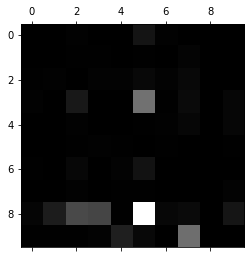

In [22]:
conf_mx = confusion_matrix(y_train,pred_train)
conf_mx = conf_mx/conf_mx.sum(axis=1)
np.fill_diagonal(conf_mx,0)
plt.matshow(conf_mx,cmap='gray')

啊哈，除了8，9以外，，数字3也有很多被误识别了成了5，你看画图明显会清晰很多呢。
# 4 多标签分类
上面我们碰到的实际问题都是将一条数据分类为一个类别，我们现在来挑战下一个数据有一或多个类别的标签的问题。
## 4.1 多标签建模
我们将上面的标签**y**追加一个奇偶标签：

In [23]:
y_multilabel = np.c_[y,(y%2==1)] # np.r_:按列连接两个矩阵;np.c_:按行连接两个矩阵
y_multilabel[0:3]

array([[0., 0.],
       [3., 1.],
       [8., 0.]])

In [24]:
from sklearn.neighbors import KNeighborsClassifier
x_train,x_test,y_train,y_test = train_test_split(X,y_multilabel,test_size=0.3,random_state=7)

mm = MinMaxScaler()
x_train_mm = mm.fit_transform(x_train)
y_train_mm = mm.transform(x_test)

knn = KNeighborsClassifier(n_neighbors=5) # knn支持多标签分类
knn.fit(x_train_mm,y_train)

KNeighborsClassifier()

In [25]:
y_train[0]

array([5., 1.])

In [26]:
knn.predict(x_train_mm[0].reshape(1,-1))

array([[5., 1.]])

## 4.2 效果评估
对于多标签分类器效果评估，有一种简单的方法就是继承二分类器的量度标准，将各标签看成独立问题计算度量值，并计算均值作为评价指标，当然也可以依据实际问题，使用叠加标签权重的度量标准加权和。

In [ ]:
pred_test = knn.predict(x_test_mm)

In [ ]:
f1_score(y_train, y_train_knn_pred, average="macro") # weighted

In [1]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)
f1_score(y_train, y_train_knn_pred, average="macro") # weighted

# 5 多输出分类
我们用一个图片清楚噪点的小案例来简单体验下，关于现实中这个问题更多的是思路整合，比如，你也可以用多个模型组合来解决。

In [38]:
# 生成噪点
noise_train = np.random.randint(0,100,(len(x_train),784))
noise_test = np.random.randint(0,100,(len(x_test),784))
# 特征追加噪点
x_train_with_noise = x_train + noise_train
x_test_with_noise = x_test + noise_test
y_train = x_train
y_test = x_test
# 建立模型
knn = KNeighborsClassifier(n_neighbors=3) 
knn.fit(x_train_with_noise,y_train)

KNeighborsClassifier(n_neighbors=3)

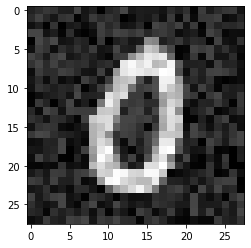

In [45]:
pred_sample = knn.predict(x_test_with_noise[0].reshape(1,-1))
plt.imshow(x_test_with_noise[0].reshape(28,-1),cmap='gray')

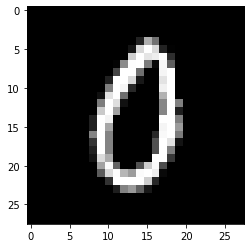

In [46]:
plt.imshow(pred_sample[0].reshape(28,-1),cmap='gray')